In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


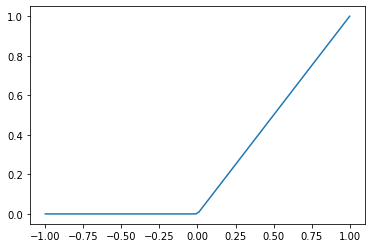

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.2
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.6,0.4]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.D

# Data

In [15]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator
from typing import *
from random import shuffle

class FixedBlockPassiveGenerator(AbsPassiveGenerator):
    def generate(self) -> Callable[..., Tensor]:
        i = np.random.randint(0,len(self.materials))
        
        def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
            return torch.ones(list((lw/size).long()))*X0[self.materials[i]]
        
        return arb_rad_length, i

In [24]:
FixedBlockPassiveGenerator().generate()[0](z=0.8, lw=volume.lw, size=volume.passive_size)

tensor([[0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932]])

In [25]:
from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:FixedBlockPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, targ_as_class:bool):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        self.targ_as_class = targ_as_class
        if self.targ_as_class:
            self.class2id = {m:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2class = {i:m for i,m in enumerate(self.passive_generator.materials)}
            self.x02id = {X0[m]:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2x0 = {i:X0[m] for i,m in enumerate(self.passive_generator.materials)}
                
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "pred_x0", "dpoca_x", "dpoca_y", "dpoca_z", "dpoca_r"],
                             'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [], 'row_wise': True}
        self.matrix_feats['feats_per_vec'] = len(self.matrix_feats['present_feats']), 
        self.matrix_feats['shape'] = (self.mu_bs, self.matrix_feats['feats_per_vec'])
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        return torch.tensor(bounds.reshape(3, -1).transpose(-1, -2), dtype=torch.float32) + (self.volume.passive_size/2)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            block, targ = self.passive_generator.generate()
            self.volume.load_rad_length(block)
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, pred[:,None], sb.location), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0)
            data[:,:,-3:] -= self.voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
            data = torch.cat((data,torch.norm(data[:,:,-3:], dim=-1, keepdim=True)), dim=-1)  # dR
            
            # Sort by dR
            idxs = data[:,:,-1].argsort()
            i = np.arange(data.shape[0])[:,None]
            data = data[i,idxs]
            
            inputs.append(data[None,:])
            targets.append(targ)
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        targets = np.array(targets)[:,None]
        if self.targ_as_class:
            for m in self.passive_generator.materials:
                targets[targets == X0[m]] = self.class2id[m]
            targets = targets.astype(int)
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':targets}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [26]:
sy = ScatterYielder(volume=volume, passive_generator=FixedBlockPassiveGenerator(materials=['beryllium', "silicon", 'lead']), mu_bs=100, n_volumes_per_fold=160, targ_as_class=True)

In [27]:
sy.n_voxels

75

In [28]:
fold = sy[0]
fold['inputs'][1].shape,fold['targets'].shape

((160, 75, 100, 9), (160, 1))

In [29]:
fold['inputs'][1][0,0,:,-1]

array([0.2600948 , 0.28064752, 0.29569572, 0.34944203, 0.38071892,
       0.38857898, 0.40298885, 0.40801555, 0.42727172, 0.42750826,
       0.42782962, 0.43151808, 0.43979737, 0.443262  , 0.4467771 ,
       0.46621037, 0.47709793, 0.4825909 , 0.49011907, 0.49333483,
       0.5054366 , 0.5139826 , 0.52211666, 0.5222749 , 0.5377925 ,
       0.5380766 , 0.56269294, 0.5633189 , 0.5720017 , 0.5941222 ,
       0.59661436, 0.6053769 , 0.609223  , 0.6139243 , 0.6158878 ,
       0.6166309 , 0.6215301 , 0.66195077, 0.66293734, 0.6756918 ,
       0.67778647, 0.68258166, 0.6922476 , 0.7001462 , 0.700456  ,
       0.7027278 , 0.70367414, 0.71167845, 0.72531813, 0.73558503,
       0.73680145, 0.73932165, 0.7394465 , 0.74464065, 0.7458243 ,
       0.74787325, 0.7554311 , 0.7662107 , 0.77573955, 0.7798058 ,
       0.78675145, 0.795177  , 0.82201046, 0.8305681 , 0.8341449 ,
       0.8359115 , 0.83986545, 0.84437436, 0.84795654, 0.8487114 ,
       0.8501105 , 0.85014266, 0.85749805, 0.8871703 , 0.89335

In [30]:
fold['targets']

array([[2],
       [2],
       [1],
       [2],
       [0],
       [2],
       [0],
       [1],
       [0],
       [1],
       [1],
       [2],
       [0],
       [0],
       [2],
       [2],
       [1],
       [1],
       [2],
       [0],
       [2],
       [0],
       [0],
       [0],
       [1],
       [2],
       [2],
       [0],
       [0],
       [1],
       [0],
       [2],
       [0],
       [0],
       [1],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [0],
       [2],
       [0],
       [0],
       [2],
       [0],
       [1],
       [0],
       [2],
       [2],
       [2],
       [1],
       [0],
       [1],
       [2],
       [1],
       [0],
       [1],
       [2],
       [1],
       [1],
       [1],
       [0],
       [2],
       [1],
       [0],
       [2],
       [1],
       [0],
       [0],
       [2],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [2],
       [0],
    

# Classifier

In [32]:
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsGraphFeatExtractor
from lumin.nn.models.blocks.gnn_blocks import *
from lumin.nn.models.initialisations import lookup_normal_init
from lumin.nn.models.layers.activations import lookup_act
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d, LCBatchNorm1d, RunningBatchNorm2d

from torch._vmap_internals import _vmap as vmap

class X0Net(AbsGraphFeatExtractor):
    row_wise:Optional[bool] = True
        
    def __init__(self, n_v:int, n_fpv:int, vox_centres:Tensor,
                 do:float=0, rep_bn:bool=False, act:str='relu',
                 lookup_init:Callable[[str,Optional[int],Optional[int]],Callable[[Tensor],None]]=lookup_normal_init,
                 lookup_act:Callable[[str],Any]=lookup_act, bn_class:Callable[[int],nn.Module]=nn.BatchNorm1d, rep_bn_class:Callable[[int],nn.Module]=nn.BatchNorm2d):
        super().__init__(n_v=n_v, n_fpv=n_fpv, do=do, bn=False, act=act, lookup_init=lookup_init, lookup_act=lookup_act, bn_class=bn_class)
        
        self.n_voxels,self.rep_bn,self.rep_bn_class = len(vox_centres),rep_bn,rep_bn_class
                
        # GNNs
        if self.rep_bn: self.init_bn = self.rep_bn_class(self.n_fpv)
        
        self.n_muon_rep, self.n_vox_rep = 40, 40
        self.muon_rep_gnn = GravNet(n_v=self.n_v, n_fpv=self.n_fpv,
                                    cat_means=True,
                                    f_slr_depth=3,
                                    n_s=4,
                                    n_lr=22,
                                    k=25,
                                    f_out_depth=1,
                                    n_out=[48],
                                    act=self.act,
                                    use_sa=False,
                                    bn=False,
                                   )
        self.muon_rep_collapser = GraphCollapser(n_v=self.n_v, n_fpv=self.muon_rep_gnn.get_out_size()[1],
                                                 flatten=False,
                                                 f_final_outs=[self.n_muon_rep],
                                                 n_sa_layers=0,
                                                 global_feat_vec=False,
                                                 act=self.act,
                                                 bn=False,
                                                )
        
        if self.rep_bn: self.muon_rep_bn = self.rep_bn_class(self.muon_rep_collapser.get_out_size()+4)
        
        self.vox_rep_gnn = GravNet(n_v=self.n_voxels, n_fpv=self.muon_rep_collapser.get_out_size()+4,
                                   cat_means=True,
                                   f_slr_depth=3,
                                   n_s=4,
                                   n_lr=22,
                                   k=12,
                                   f_out_depth=1,
                                   n_out=[48],
                                   act=self.act,
                                   use_sa=False,
                                   bn=False,
                                  )
        self.vox_rep_collapser = GraphCollapser(n_v=self.n_voxels, n_fpv=self.vox_rep_gnn.get_out_size()[1],
                                                flatten=False,
                                                f_final_outs=[self.n_vox_rep],
                                                n_sa_layers=0,
                                                global_feat_vec=False,
                                                act=self.act,
                                                bn=False,
                                               )
        
        # Relative voxel positions
        self.vox_centres = vox_centres  # (voxel,coords)
        vox_dists = self.vox_centres[None]-self.vox_centres[:,None]  # (voxel,voxel,coords)
        self.register_buffer('vox_dists', torch.cat((vox_dists,vox_dists.norm(dim=-1, keepdim=True)), dim=-1))
        
    def forward(self, x:Tensor) -> Tensor:
        r'''x=(volume,voxel,muon,feature)'''
        if self.rep_bn: x = self.init_bn(x.transpose(1,-1)).transpose(1,-1)
        
        def get_muon_rep(x:Tensor) -> Tensor:
            r'''(voxel,muon,feature)'''
            return self.muon_rep_collapser(self.muon_rep_gnn(x))
        
#         muon_rep = vmap(get_muon_rep)(x)  # (volume,voxel,muon_rep)
        muon_rep = torch.stack([get_muon_rep(v) for v in x.unbind()], dim=0)  # (volume,voxel,muon_rep)
        muon_rep = muon_rep[:,None].expand(-1,self.n_voxels, -1,-1)  # (volume,voxel,voxel,muon_rep)
        muon_rep = torch.cat((muon_rep, self.vox_dists[None].expand(len(muon_rep), -1, -1, -1)), dim=-1)
        if self.rep_bn: muon_rep = self.muon_rep_bn(muon_rep.transpose(1,-1)).transpose(1,-1)
        
        def get_vox_rep(x:Tensor) -> Tensor:
            r'''(voxel,voxel,muon_rep)'''
            return self.vox_rep_collapser(self.vox_rep_gnn(x))
        
#         vox_rep = vmap(get_vox_rep)(muon_rep)  # (volume,voxel,class)
        vox_rep = torch.stack([get_vox_rep(v) for v in muon_rep.unbind()], dim=0)  # (volume,voxel,class)
        return vox_rep
    
    def get_out_size(self) -> Tuple[int,int]: return self.n_voxels, self.n_vox_rep*2

In [33]:
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.optimisation.hyper_param import lr_find

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(X0Net, vox_centres=sy.voxel_centres, rep_bn=True, rep_bn_class=RunningBatchNorm2d, act='swish'),
               collapser=partial(GraphCollapser,
                                 flatten=True,
                                 f_final_outs=[10],
                                 bn=False,
                                 act='swish',
                                 bn_class=RunningBatchNorm1d
                                ))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('multiclass', cont_feats=sy.matrix_feats['present_feats'], n_out=len(sy.passive_generator.materials), 
                             opt_args=opt_args, body=body, head=head)
print(Model(model_builder))

Inputs:
9 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'pred_x0', 'dpoca_x', 'dpoca_y', 'dpoca_z', 'dpoca_r']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): X0Net(
      (init_bn): RunningBatchNorm2d()
      (muon_rep_gnn): GravNet(
        (grav_layers): ModuleList(
          (0): GravNetLayer(
            (f_slr): Sequential(
              (0): Sequential(
                (0): Linear(in_features=18, out_features=52, bias=True)
                (1): Swish()
              )
              (1): Sequential(
                (0): Linear(in_features=52, out_features=52, bias=True)
                (1): Swish()
              )
              (2): Sequential(
                (0): Linear(in_features=52, out_features=26, bias=True)
                (1): Swish()
              )
            )
            (f_out): Sequential(
              (0): Sequential(
 

In [34]:
sy.get_data_count(0)

160

LR finder took 121.971s 


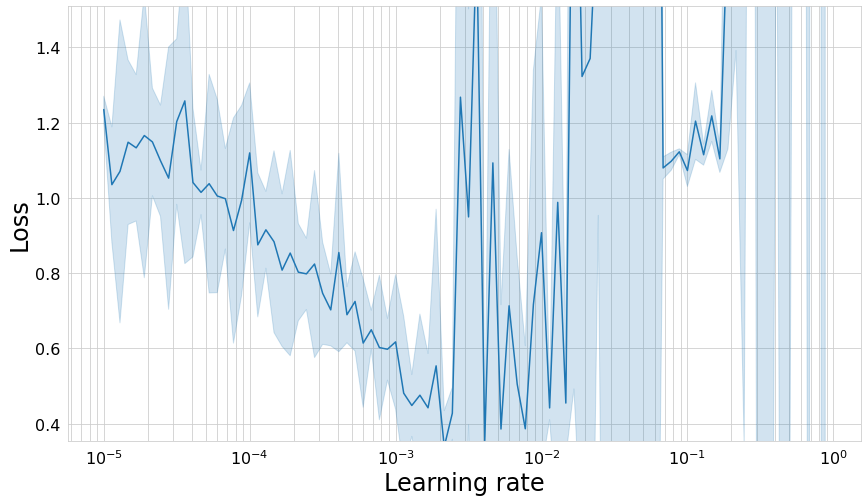

In [35]:
lr_finder = lr_find(sy, model_builder, bs=16, lr_bounds=[1e-5,1e0], n_repeats=3, bulk_move=False)

In [38]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import RocAucScore
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = (partial(RocAucScore, average='weighted', multi_class='ovr'))

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


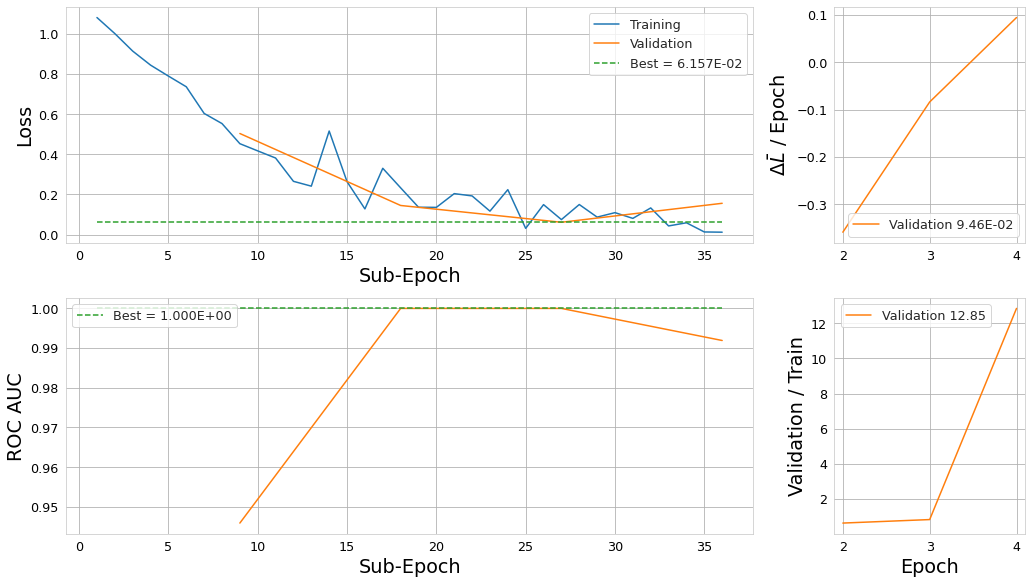

KeyboardInterrupt: 

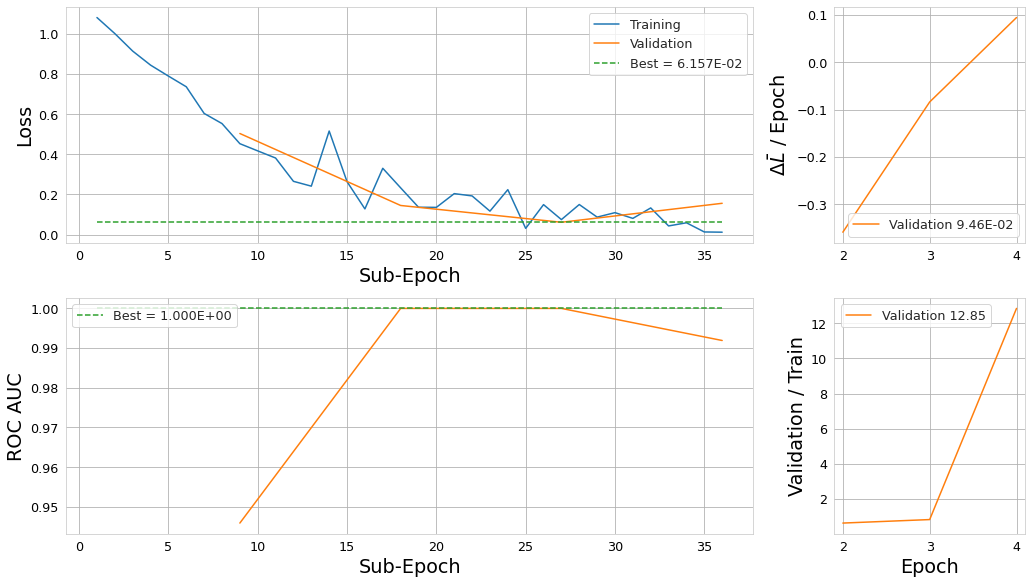

In [39]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=16,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=15,
                 bulk_move=False)

In [40]:
model = Model.from_save('train_weights/model_id_0/best.h5', model_builder)

In [41]:
data = sy[0]

In [42]:
pred = model.predict(data['inputs'])

In [43]:
pred

array([[9.74285185e-01, 2.44892724e-02, 1.22555497e-03],
       [9.86400187e-01, 1.26409791e-02, 9.58917430e-04],
       [2.50936432e-06, 6.53323013e-06, 9.99990940e-01],
       [9.60763037e-01, 3.89376990e-02, 2.99232895e-04],
       [3.82428139e-01, 6.13910258e-01, 3.66155407e-03],
       [9.75737333e-01, 2.36080177e-02, 6.54600328e-04],
       [3.02835494e-01, 6.93179607e-01, 3.98492999e-03],
       [5.30530751e-01, 4.64118540e-01, 5.35074808e-03],
       [6.16388775e-07, 4.02621163e-06, 9.99995291e-01],
       [9.84876692e-01, 1.43309031e-02, 7.92478968e-04],
       [4.96664354e-09, 9.95434917e-08, 9.99999940e-01],
       [8.78353715e-01, 1.17259972e-01, 4.38623037e-03],
       [9.83232141e-01, 1.53248953e-02, 1.44298025e-03],
       [9.88482296e-01, 1.08099692e-02, 7.07727566e-04],
       [9.81321752e-01, 1.76275466e-02, 1.05079252e-03],
       [2.41963074e-01, 7.54786253e-01, 3.25062778e-03],
       [1.55811116e-01, 8.40666354e-01, 3.52254207e-03],
       [9.86657739e-01, 1.24244

In [44]:
data['inputs'][1][0,0]

array([[ 2.29316950e-03,  2.14620680e-03, -2.61264009e-04,
         2.77562882e-04,  3.02311927e-01,  5.47052622e-02,
         1.69154376e-01,  1.52390271e-01,  2.34155223e-01],
       [ 2.00854987e-03,  3.20456922e-04, -7.87683384e-05,
        -4.93929256e-04,  7.17355192e-01,  7.43869543e-02,
         2.46504307e-01,  2.23224908e-01,  3.40774328e-01],
       [ 7.07367063e-03,  5.29119931e-03, -2.34941617e-04,
         3.17104539e-04,  3.81070860e-02,  2.31909096e-01,
        -4.56014574e-02,  3.27374190e-01,  4.03776169e-01],
       [ 3.61553580e-03,  3.39705124e-03, -7.34908390e-04,
        -7.91209750e-04,  1.21073678e-01,  2.32690454e-01,
        -7.02471212e-02,  3.39028060e-01,  4.17156488e-01],
       [ 1.65702403e-03,  2.68585980e-03,  5.14002051e-04,
        -3.18476639e-04,  2.98100203e-01,  1.08473241e-01,
         2.82588392e-01,  2.96252400e-01,  4.23542351e-01],
       [ 1.83033943e-03,  7.64364749e-03, -4.54656605e-04,
        -1.16047129e-04,  5.01271077e-02,  1.221090

In [45]:
pred_class = pred.argmax(-1)
# pred_class = pred > 0.5

In [46]:
pred_class

array([0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2,
       2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0,
       2, 1, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0, 0,
       2, 2, 0, 1, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 1,
       2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2,
       0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0,
       0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1,
       1, 1, 1, 0, 0, 0])

In [57]:
targs = data['targets'].flatten()

In [58]:
targs

array([0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2,
       2, 2, 2, 1, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0,
       2, 1, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0,
       2, 2, 0, 1, 2, 1, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1,
       2, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2,
       0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0,
       1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1,
       1, 1, 1, 0, 0, 0])

In [59]:
from sklearn.metrics import confusion_matrix, roc_auc_score

In [60]:
confusion_matrix(targs, pred_class)

array([[56,  0,  0],
       [11, 51,  0],
       [ 0,  0, 42]])

In [69]:
roc_auc_score(y_true=targs, y_score=pred, multi_class='ovr', average='weighted')

0.9996283850078493